Something about air travel being stressful. From October 1st to November 12th of 2025 the United States experienced the longest government shutdown on record. Various news outlets proclaimed travel impacts and significant delays. https://www.msn.com/en-us/autos/general/flight-disruptions-from-shutdown-worsen-delta-united-offer-extra-pay-to-crew-flights/ar-AA1Q9FPb?ocid=BingNewsVerp.

How true are these stories? Is there truly a significant difference in delays during the shutdown than during normal operations (in relation to the number of flights)? According to these news articles, the cancellations and delays are mainly due to staffing shortages, as workers are not being paid for their working hours. The National Airspace System (NAS) includes the airports, the air traffic control systems and more, along with the manpower to run it. So if the delays are caused by air traffic controllers and TSA agents not being able to come to work then the delays should mainly be in the 'NAS' category.

Air delays - network anaylsis. which flights are more delayed than normal?  Are there certain routes that experience more delays than normal? Certain airports/airlines that experience more than average delays? network graph of delays between airports

https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr

In [ ]:
!pip install airportsdata
!pip install geopandas
!pip install pygris

In [1]:
import pandas as pd
from datetime import datetime
import pygris
from pygris import states
from pygris.utils import shift_geometry
import networkx as nx
import airportsdata
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
#Step 2 import the data into a pandas dataframe
march = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2025_3/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_3.csv')
march.head() #examine the dataset

C:\Users\abiga\AppData\Local\Temp\ipykernel_4044\51377088.py:2: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  march = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2025_3/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_3.csv')


Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2025        1      3           1          6  2025-03-01                AA   
1  2025        1      3           2          7  2025-03-02                AA   
2  2025        1      3           3          1  2025-03-03                AA   
3  2025        1      3           4          2  2025-03-04                AA   
4  2025        1      3           5          3  2025-03-05                AA   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     19805                          AA      N112AN  ...   
1                     19805                          AA      N110AN  ...   
2                     19805                          AA      N112AN  ...   
3                     19805                          AA      N101NN  ...   
4                     19805                          AA      N102NN  ...   

   Div4TailNum  Div5Airport  Div5AirportID  Div5AirportSeqID Div5WheelsOn  \
0          NaN          NaN            NaN               NaN          NaN   
1          NaN          NaN            NaN               NaN          NaN   
2          NaN          NaN            NaN               NaN          NaN   
3          NaN          NaN            NaN               NaN          NaN   
4          NaN          NaN            NaN               NaN          NaN   

  Div5TotalGTime Div5LongestGTime  Div5WheelsOff Div5TailNum  Unnamed: 109  
0            NaN              NaN            NaN         NaN           NaN  
1            NaN              NaN            NaN         NaN           NaN  
2            NaN              NaN            NaN         NaN           NaN  
3            NaN              NaN            NaN         NaN           NaN  
4            NaN              NaN            NaN         NaN           NaN  

[5 rows x 110 columns]

In [5]:
#Step 3 clean the data
#There are a lot of columns here that I am not interested in
#3a. filter down to just the columns I am interested in

#To answer my question I need columns that identify the airline, the flight, the date, the destination, the origin and the type of delay
airDataM = march[['FlightDate', 'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
              'Origin', 'OriginCityName', 'OriginCityMarketID', 'DepDelay',
              'Dest', 'DestCityName', 'DestCityMarketID', 'ArrDelay',
              'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].copy()
#I want to rename some of them
airDataM.rename(columns = {'DOT_ID_Reporting_Airline':'DOT_ID', 'IATA_CODE_Reporting_Airline':'IATA_Code'}, inplace=True)

airDataM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600872 entries, 0 to 600871
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FlightDate          600872 non-null  object 
 1   DOT_ID              600872 non-null  int64  
 2   IATA_Code           600872 non-null  object 
 3   Tail_Number         600104 non-null  object 
 4   Origin              600872 non-null  object 
 5   OriginCityName      600872 non-null  object 
 6   OriginCityMarketID  600872 non-null  int64  
 7   DepDelay            594263 non-null  float64
 8   Dest                600872 non-null  object 
 9   DestCityName        600872 non-null  object 
 10  DestCityMarketID    600872 non-null  int64  
 11  ArrDelay            592301 non-null  float64
 12  CarrierDelay        116034 non-null  float64
 13  WeatherDelay        116034 non-null  float64
 14  NASDelay            116034 non-null  float64
 15  SecurityDelay       116034 non-nul

The airportsdata package is a nested dictionary object that contains information on airports and is keyed by the airport's code. In this case, the key is the airport IATA code which is also included in the dataframe. I am only interested in domestic flights, so I will use the airportsdata to filter the dataframe to just the flights that have an origin and a destination in the united states

In [7]:
#This is a nested dictionary object that contains information about airports
iata_airports = airportsdata.load('IATA') # key is the IATA location code
print(iata_airports['STT']) #looking at the structure of the nested dictionary

{'icao': 'TIST', 'iata': 'STT', 'name': 'Cyril E King Airport', 'city': 'Charlotte Amalie', 'subd': 'Virgin Islands', 'country': 'US', 'elevation': 23.6, 'lat': 18.33731, 'lon': -64.97333, 'tz': 'America/St_Thomas', 'lid': 'STT'}


In [9]:
USairports = [
    key
    for key, values in iata_airports.items()
    if values.get('country')== 'US'and values.get('subd') not in ['Puerto Rico', 'Virgin Islands']]
 #For this, I am not considering Puerto Rico or the virgin islands as domestic 'States'

In [13]:
#3b. Now that columns have been selected, the rows need to be filtered for the data wanted.

# Filter rows where both Origin and Dest are in the US airport codes
usAirDataM = airDataM[
    airDataM['Origin'].isin(USairports) &
    airDataM['Dest'].isin(USairports)
]

#Officially delayed flights are flights that have been delayed by over 15 min
officialDelayM = usAirDataM[usAirDataM.ArrDelay>= 15]
officialDelayM.head()

FlightDate  DOT_ID IATA_Code Tail_Number Origin   OriginCityName  \
3   2025-03-04   19805        AA      N101NN    JFK     New York, NY   
54  2025-03-24   19805        AA      N106NN    LAX  Los Angeles, CA   
59  2025-03-29   19805        AA      N106NN    LAX  Los Angeles, CA   
72  2025-03-11   19805        AA      N113AN    JFK     New York, NY   
75  2025-03-14   19805        AA      N111ZM    JFK     New York, NY   

    OriginCityMarketID  DepDelay Dest     DestCityName  DestCityMarketID  \
3                31703       0.0  LAX  Los Angeles, CA             32575   
54               32575      -6.0  JFK     New York, NY             31703   
59               32575       2.0  JFK     New York, NY             31703   
72               31703     115.0  LAX  Los Angeles, CA             32575   
75               31703     566.0  LAX  Los Angeles, CA             32575   

    ArrDelay  CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  \
3       22.0           0.0           0.0      22.0            0.0   
54      19.0           0.0           0.0      19.0            0.0   
59      21.0           2.0           0.0      19.0            0.0   
72     125.0         115.0           0.0      10.0            0.0   
75     598.0          42.0           0.0      32.0            0.0   

    LateAircraftDelay  
3                 0.0  
54                0.0  
59                0.0  
72                0.0  
75              524.0

In [15]:
#Filtering based on delay type
carrierM = usAirDataM[usAirDataM.CarrierDelay > 0]
weatherM = usAirDataM[usAirDataM.WeatherDelay > 0]
nasM = usAirDataM[usAirDataM.NASDelay > 0]
securityM = usAirDataM[usAirDataM.SecurityDelay > 0]
lateM = usAirDataM[usAirDataM.LateAircraftDelay > 0]

114038


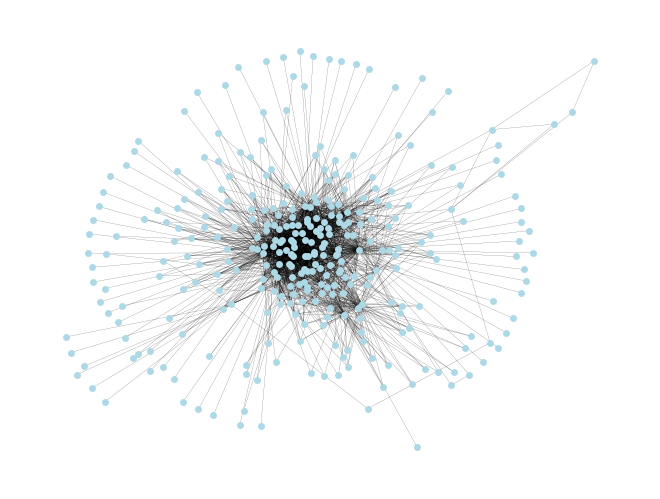

In [17]:
#Set the edges to an array of origin and destination from only the officially delayed flights
edges = officialDelayM[['Origin', 'Dest']].values
print(len(edges))
#Create a networkx object
M = nx.from_edgelist(edges)

#sets the sizes of the nodes to the amount of connections
deg = nx.degree(M)
sizes = [5 * deg[iata] for iata in M.nodes]

#labels only the nodes that
labels = {iata: iata if deg[iata] >= 20 else ''
          for iata in M.nodes}
#Graphing options
options = { 'node_color': 'lightblue',
            'node_size': 25,
            'linewidths': 0,
            'width': 0.1,
            'with_labels': False}
#Preliminary graph, without any weighting or anything
nx.draw(M, **options)

Now to build the network overlayed on the map. First, create the map with pygris. Next, filter the latitude and longitude from the airportsdata dictionary. Next, transform the latitude and longitude data to a geopandas dataframe so it can be used with pygris. During this step it is also being filtered for just the airports in the US. Then the aiport latitudes and longitudes are shifted with pygris to map to the correct locations in the shifted map. For the plot, first the node_positions are built from shifted airport data. Figure axes are set, the US map is plotted, options for the network is set and finally the network is plotted.

In [19]:
us = states(cb=True, resolution="20m")
us_rescaled = shift_geometry(us)

Using the default year of 2024


In [21]:
#removing any unnessesary information from the airport dictionaries
remove_keys = {'icao', 'iata', 'name', 'city', 'subd', 'country', 'elevation', 'tz', 'lid'}

airports = {
    code: {k: v for k, v in data.items() if k not in remove_keys}
    for code, data in iata_airports.items()
}

In [23]:
airport_list = []
for iata_code, data in airports.items():
  if iata_code in USairports:
    airport_list.append({
        'iata': iata_code,
        'lat': data['lat'],
        'lon': data['lon']
    })

airports_df = pd.DataFrame(airport_list)

# Convert DataFrame to GeoDataFrame
airports_gdf = gpd.GeoDataFrame(
    airports_df,
    geometry=gpd.points_from_xy(airports_df.lon, airports_df.lat),
    crs="EPSG:4326" # make sure we are mapping to the same coordinate system as the pygris map
)
# Reproject airports to match pygris states CRS
airports_gdf = airports_gdf.to_crs(us_rescaled.crs)

# Shift airport geometries using pygris
airports_shifted = shift_geometry(airports_gdf)

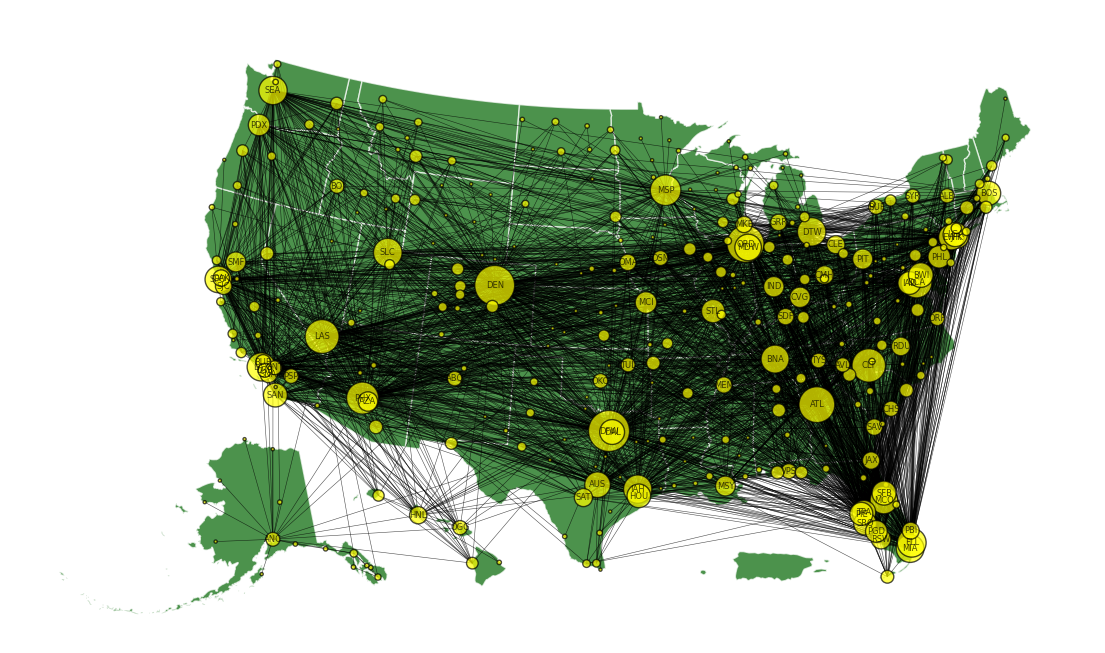

In [25]:
# Build node positions
node_positions = {
    row['iata']: (row.geometry.x, row.geometry.y)
    for idx, row in airports_shifted.iterrows()
}

# Plot!
fig, ax = plt.subplots(figsize=(14, 10)) # Set the axes

us_rescaled.plot(ax=ax, color="darkgreen", edgecolor="white", alpha=0.7) # Map of the US

options = {'pos': node_positions,
    'ax': ax,
    'node_size':sizes,
    'node_color':'yellow',
    'edgecolors':'black',
    'width':0.4,
    'alpha': 0.7,
    'labels' : labels,
    'font_size':6}

nx.draw_networkx(M, **options)


ax.set_axis_off()
plt.show()

# National Airspace Systems

In [27]:
#Set the edges to an array of origin and destination from only the Carrier delayed flights
edges = nasM[['Origin', 'Dest']].values
print(len(edges))

#Create a networkx object
NM = nx.from_edgelist(edges)

#sets the sizes of the nodes to the amount of connections
deg = nx.degree(NM)
sizes = [5 * deg[iata] for iata in NM.nodes]

#labels only the nodes that
labels = {iata: iata if deg[iata] >= 20 else ''
          for iata in NM.nodes}

59040


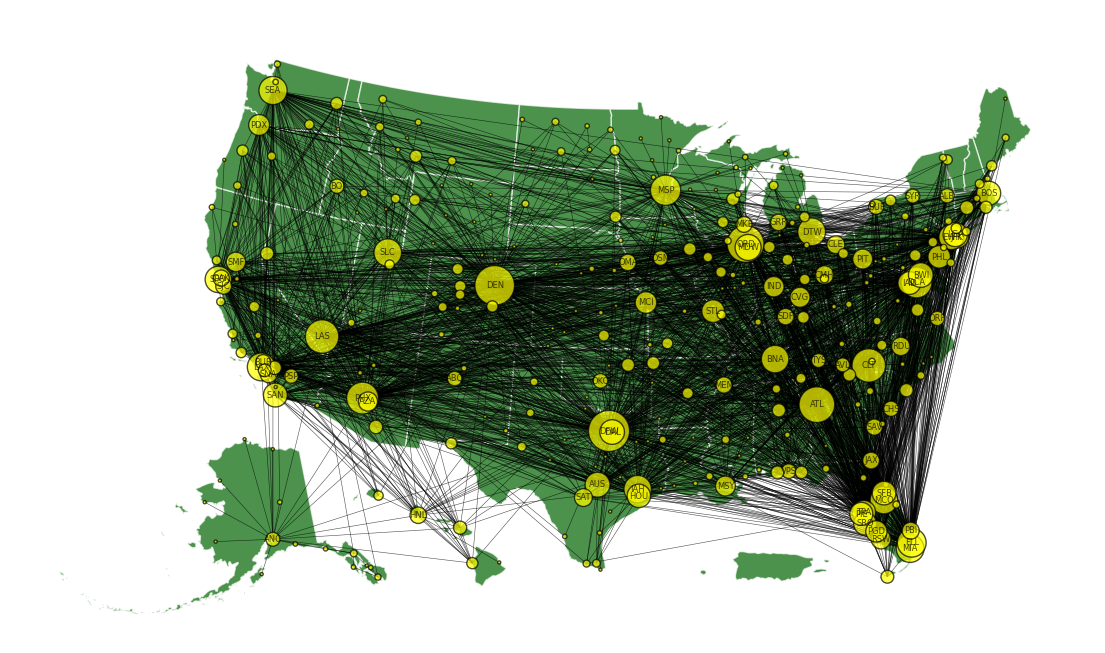

In [29]:
fig, ax = plt.subplots(figsize=(14, 10)) # Set the axes

us_rescaled.plot(ax=ax, color="darkgreen", edgecolor="white", alpha=0.7) # Map of the US

options = {'pos': node_positions,
    'ax': ax,
    'node_size':sizes,
    'node_color':'yellow',
    'edgecolors':'black',
    'width':0.4,
    'alpha': 0.7,
    'labels' : labels,
    'font_size':6}

nx.draw_networkx(NM, **options)


ax.set_axis_off()
plt.show()

In [ ]:
#STATS

Here is where I would analyze the data from October 1st to November 12th if it were available. For now, I am going look at July's data and compare the two months. 

In [35]:
#Importing the June data
july = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2025_7/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_7.csv')
july.head() #examine the dataset

C:\Users\abiga\AppData\Local\Temp\ipykernel_4044\964616065.py:2: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  july = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2025_7/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2025_7.csv')


Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2025        3      7          23          3  2025-07-23                AA   
1  2025        3      7          24          4  2025-07-24                AA   
2  2025        3      7          25          5  2025-07-25                AA   
3  2025        3      7          26          6  2025-07-26                AA   
4  2025        3      7          27          7  2025-07-27                AA   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     19805                          AA      N450AN  ...   
1                     19805                          AA      N431AN  ...   
2                     19805                          AA      N444UW  ...   
3                     19805                          AA      N462AA  ...   
4                     19805                          AA      N458AL  ...   

   Div4TailNum  Div5Airport  Div5AirportID  Div5AirportSeqID Div5WheelsOn  \
0          NaN          NaN            NaN               NaN          NaN   
1          NaN          NaN            NaN               NaN          NaN   
2          NaN          NaN            NaN               NaN          NaN   
3          NaN          NaN            NaN               NaN          NaN   
4          NaN          NaN            NaN               NaN          NaN   

  Div5TotalGTime Div5LongestGTime  Div5WheelsOff Div5TailNum  Unnamed: 109  
0            NaN              NaN            NaN         NaN           NaN  
1            NaN              NaN            NaN         NaN           NaN  
2            NaN              NaN            NaN         NaN           NaN  
3            NaN              NaN            NaN         NaN           NaN  
4            NaN              NaN            NaN         NaN           NaN  

[5 rows x 110 columns]

In [37]:
#Step 3 clean the data
#There are a lot of columns here that I am not interested in
#3a. filter down to just the columns I am interested in

#To answer my question I need columns that identify the airline, the flight, the date, the destination, the origin and the type of delay
airDataJ = july[['FlightDate', 'DOT_ID_Reporting_Airline', 'IATA_CODE_Reporting_Airline', 'Tail_Number',
              'Origin', 'OriginCityName', 'OriginCityMarketID', 'DepDelay',
              'Dest', 'DestCityName', 'DestCityMarketID', 'ArrDelay',
              'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].copy()
#I want to rename some of them
airDataJ.rename(columns = {'DOT_ID_Reporting_Airline':'DOT_ID', 'IATA_CODE_Reporting_Airline':'IATA_Code'}, inplace=True)

airDataJ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631428 entries, 0 to 631427
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   FlightDate          631428 non-null  object 
 1   DOT_ID              631428 non-null  int64  
 2   IATA_Code           631428 non-null  object 
 3   Tail_Number         629734 non-null  object 
 4   Origin              631428 non-null  object 
 5   OriginCityName      631428 non-null  object 
 6   OriginCityMarketID  631428 non-null  int64  
 7   DepDelay            616879 non-null  float64
 8   Dest                631428 non-null  object 
 9   DestCityName        631428 non-null  object 
 10  DestCityMarketID    631428 non-null  int64  
 11  ArrDelay            612811 non-null  float64
 12  CarrierDelay        177012 non-null  float64
 13  WeatherDelay        177012 non-null  float64
 14  NASDelay            177012 non-null  float64
 15  SecurityDelay       177012 non-nul

Now that I have a list of US airport codes and the columns that I am interested in, the data can be filtered for only delayed domestic flights.

In [39]:
#3b. Now that columns have been selected, the rows need to be filtered for the data wanted.

# Filter rows where both Origin and Dest are in the US airport codes
usAirDataJ = airDataJ[
    airDataJ['Origin'].isin(USairports) &
    airDataJ['Dest'].isin(USairports)
]

#Officially delayed flights are flights that have been delayed by over 15 min
officialDelayJ = usAirDataJ[usAirDataJ.ArrDelay>= 15]
officialDelayJ.head()

FlightDate  DOT_ID IATA_Code Tail_Number Origin OriginCityName  \
1   2025-07-24   19805        AA      N431AN    MIA      Miami, FL   
10  2025-07-02   19805        AA      N916NN    LGA   New York, NY   
14  2025-07-06   19805        AA      N919AN    LGA   New York, NY   
15  2025-07-07   19805        AA      N820NN    LGA   New York, NY   
20  2025-07-12   19805        AA      N809NN    LGA   New York, NY   

    OriginCityMarketID  DepDelay Dest   DestCityName  DestCityMarketID  \
1                32467      85.0  CLT  Charlotte, NC             31057   
10               31703      -3.0  MIA      Miami, FL             32467   
14               31703       0.0  MIA      Miami, FL             32467   
15               31703      97.0  MIA      Miami, FL             32467   
20               31703     421.0  MIA      Miami, FL             32467   

    ArrDelay  CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  \
1       74.0           0.0           0.0       0.0            0.0   
10      45.0           0.0           0.0      45.0            0.0   
14      32.0           0.0           0.0      32.0            0.0   
15      72.0           0.0           0.0       0.0            0.0   
20     396.0          68.0           0.0       0.0            0.0   

    LateAircraftDelay  
1                74.0  
10                0.0  
14                0.0  
15               72.0  
20              328.0

In [41]:
#Filtering based on delay type
carrierJ = usAirDataJ[usAirDataJ.CarrierDelay > 0]
weatherJ = usAirDataJ[usAirDataJ.WeatherDelay > 0]
nasJ = usAirDataJ[usAirDataJ.NASDelay > 0]
securityJ = usAirDataJ[usAirDataJ.SecurityDelay > 0]
lateJ = usAirDataJ[usAirDataJ.LateAircraftDelay > 0]

Step 4 is building the network graph.  First make a list of the edges, with one node being origin and the other being destination. Next, from the list of edges create a networkx object. The network will be overlayed on a US map, which will be constructed using pygris (documentation here https://walker-data.com/pygris/02-geometries/)

174749


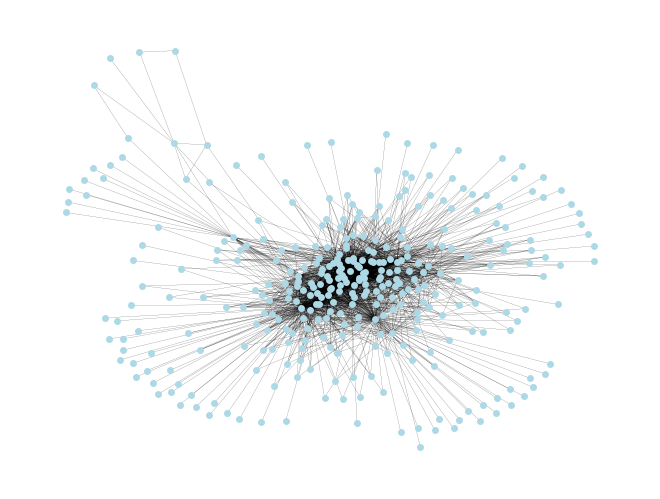

In [43]:
#Set the edges to an array of origin and destination from only the officially delayed flights
edges = officialDelayJ[['Origin', 'Dest']].values
print(len(edges))
#Create a networkx object
G = nx.from_edgelist(edges)

#sets the sizes of the nodes to the amount of connections
deg = nx.degree(G)
sizes = [5 * deg[iata] for iata in G.nodes]

#labels only the nodes that
labels = {iata: iata if deg[iata] >= 20 else ''
          for iata in G.nodes}
#Graphing options
options = { 'node_color': 'lightblue',
            'node_size': 25,
            'linewidths': 0,
            'width': 0.1,
            'with_labels': False}
#Preliminary graph, without any weighting or anything
nx.draw(G, **options)

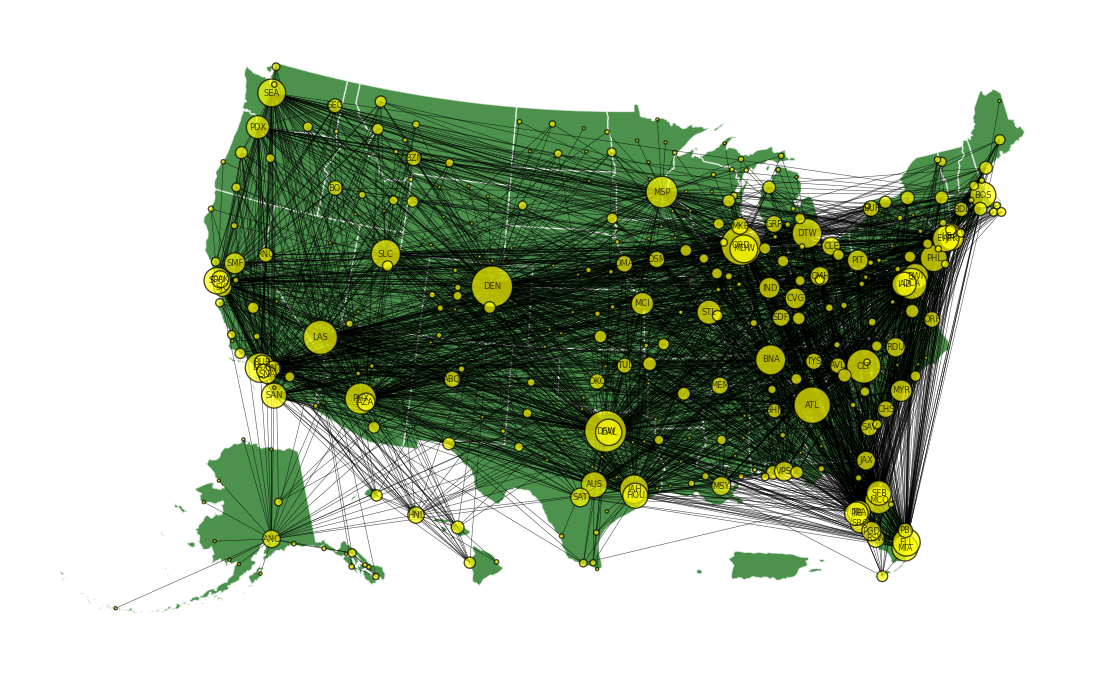

In [45]:
# Build node positions
node_positions = {
    row['iata']: (row.geometry.x, row.geometry.y)
    for idx, row in airports_shifted.iterrows()
}

# Plot!
fig, ax = plt.subplots(figsize=(14, 10)) # Set the axes

us_rescaled.plot(ax=ax, color="darkgreen", edgecolor="white", alpha=0.7) # Map of the US

options = {'pos': node_positions,
    'ax': ax,
    'node_size':sizes,
    'node_color':'yellow',
    'edgecolors':'black',
    'width':0.4,
    'alpha': 0.7,
    'labels' : labels,
    'font_size':6}

nx.draw_networkx(G, **options)


ax.set_axis_off()
plt.show()


Now that all of the official flight delays are plotted, we can see there there are a lot of black edges in the image. Still, we can see the biggest nodes are the airports that have the most delays Denver, Atlanta, Charlotte, Chicago O'hare and Dallas Fort Worth are the main culprets for delays. 

# National Airspace Systems

In [47]:
#Set the edges to an array of origin and destination from only the Carrier delayed flights
edges = nasJ[['Origin', 'Dest']].values
print(len(edges))

#Create a networkx object
NJ = nx.from_edgelist(edges)

#sets the sizes of the nodes to the amount of connections
deg = nx.degree(NJ)
sizes = [5 * deg[iata] for iata in NJ.nodes]

#labels only the nodes that
labels = {iata: iata if deg[iata] >= 20 else ''
          for iata in NJ.nodes}

85948


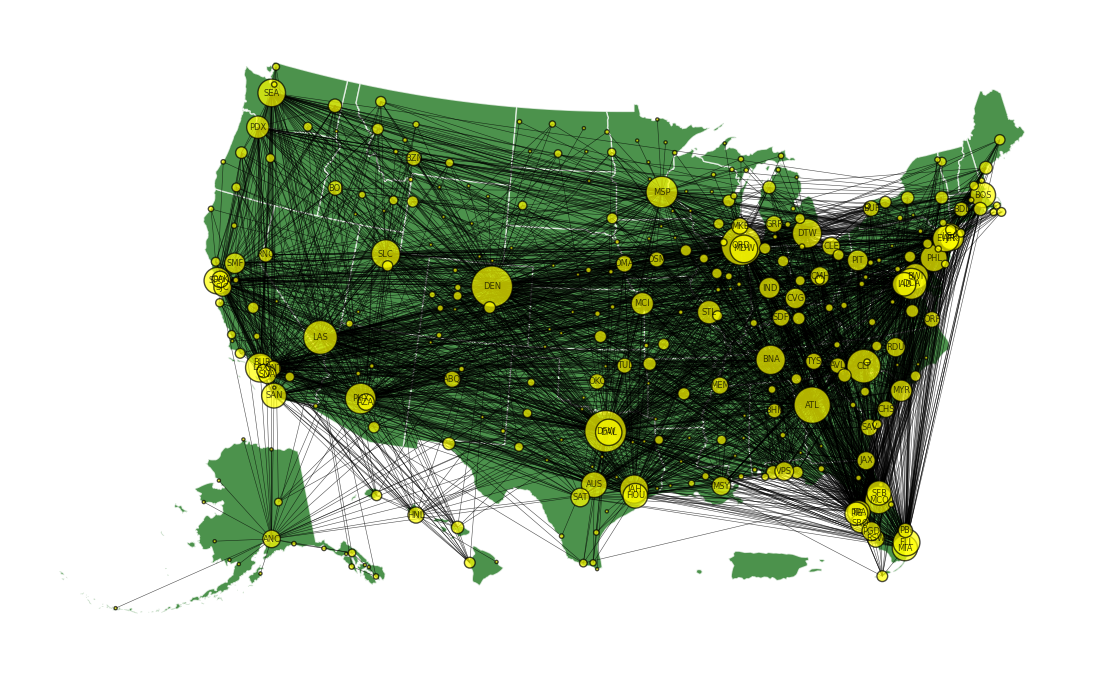

In [49]:
fig, ax = plt.subplots(figsize=(14, 10)) # Set the axes

us_rescaled.plot(ax=ax, color="darkgreen", edgecolor="white", alpha=0.7) # Map of the US

options = {'pos': node_positions,
    'ax': ax,
    'node_size':sizes,
    'node_color':'yellow',
    'edgecolors':'black',
    'width':0.4,
    'alpha': 0.7,
    'labels' : labels,
    'font_size':6}

nx.draw_networkx(NJ, **options)


ax.set_axis_off()
plt.show()

In [ ]:
#STATS
nx.betweenness_centrality(NJ)

Comparison between the two graphs using graph edit distance (GED) which is the minimum cost of transforming one graph to another. A higher number would indicate not-so similar graphs.

In [ ]:
for v in nx.optimize_graph_edit_distance(NM, NJ):
    minv = v
print(minv)